In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# knn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from tensorflow import keras
from tensorflow.keras import layers
import random

In [2]:
from string import punctuation

In [3]:
with open("Lys_mykyta.txt", encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")  # We remove newlines chars for nicer display
text = text.replace("\t", " ")
text = text.replace("  ", " ")
text = text.translate(str.maketrans("", "", punctuation))
print("Corpus length:", len(text))

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Corpus length: 81337
Total chars: 41


In [4]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [5]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [6]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, LambdaCallback

In [8]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.4, 0.5, 0.6, 0.7]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        # print(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            # print(next_char)
        print("-----Generated:", generated)
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [9]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)

callbacks = [print_callback, reduce_lr]

In [10]:
model.fit(x, y, batch_size=128, epochs=40, callbacks=callbacks)

Epoch 1/40

212/212 [==============================] - ETA: 0s - loss: 2.7210
----- Generating text after Epoch: 0
----- diversity: 0.4
----- Generating with seed: "іряти тебе дозволь тут до мене він уміло"
-----Generated: іряти тебе дозволь тут до мене він уміло в ска да на портька на поба та ста де да вось не подо хо не в реди за де на в на ні та до ду ся в на не на на де падне на продни вся не сь сь до ду проді в бан в поли та ва та подо на подя по ві з вадли к та мали в не пода за та до не лис за не за де ста не це побо за м не став та та сто ба ста де руд в не не не вад сба дро не та ста та не за та смін о та ба порита в поду на ве да ти в ваз між ша
----- diversity: 0.5
----- Generating with seed: "іряти тебе дозволь тут до мене він уміло"
-----Generated: іряти тебе дозволь тут до мене він уміло бу не та старі в са та по ста до доба ми помна і в кале на і поль в за за ві за да ла на не поду не в марк о в да не ца да до справ на ж від мий не та поло в да ва не вали в са в не ве х 

In [11]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [12]:
generate_text(500, 0.55)

'а нога була в зубах а микита поки рюмав «хать на ід мишей вало з полів вас на раз одно ти від ти щоб у бармиш спіламити – що я віркував «кран буечеш вмій – ти прокліли звід по моїси\xa0 листі люди не внюва ви візьм звіст зайіли сміло мене й пригада до мене повнались ви бігахане вона серце розстався мастим ми рі не з вітяться на суд рибив той небити не браю знаю – аж охдятавши на молити – дастерем мовили – ось давно в мук по себе в харто наш ліс провили свову від почуть в двари в голосили та не вмору – ти поклай год нине такти жуло оченьк'

In [2]:
from transformers import pipeline

In [12]:

pipe = pipeline("text-generation", model="benjamin/gpt2-wechsel-ukrainian")
pipe("Сьогодні був сонячний та ясний день. Я ")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Сьогодні був сонячний та ясний день. Я ___ працювала на виробництві в цей прекрасний день. Сьогодні о 10.00 годині ранку, моя перша робота була в полі. Погода була дуже гарна та сонячна. Я пішла на те місце, на котре'}]

In [257]:
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf

In [246]:
content_image_path = "content.jpg"
style_image_path = "style.jpg"

In [269]:
def load_and_process_image(image_path):
    img = image.load_img(image_path)
    plt.axis('off')
    plt.imshow(img)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [264]:
def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], img.shape[3]))
    # Виконання зворотньої обробки, що відміняє нормалізацію, яку було застосовано під час попередньої обробки
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

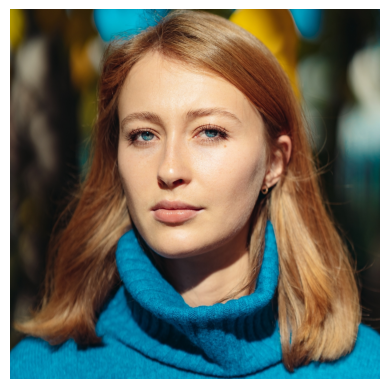

In [272]:
content_image = load_and_process_image(content_image_path)

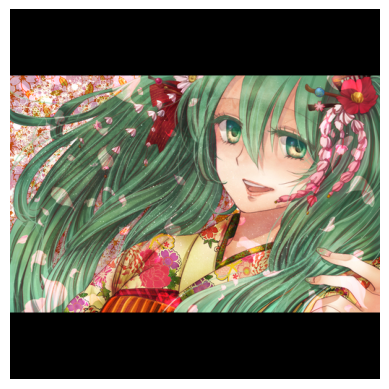

In [271]:
style_image = load_and_process_image(style_image_path)

In [250]:
content_layer = 'block5_conv2'
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

In [251]:
def vgg_model(layer_names):
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = Model(inputs=vgg.input, outputs=outputs)
    return model

In [252]:
def content_cost(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

In [253]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [254]:
def style_cost(style, generated):
    style = gram_matrix(style)
    generated = gram_matrix(generated)
    return tf.reduce_mean(tf.square(style - generated))

In [255]:
def total_cost(content_cost, style_cost, alpha=10, beta=40):
    return alpha * content_cost + beta * style_cost

In [258]:
generated_image = tf.Variable(content_image, dtype=tf.float32)

vgg = vgg_model(style_layers + [content_layer])
optimizer = tf.optimizers.Adam(learning_rate=5.0)

80134624/80134624 [==============================] - 14s 0us/step


In [259]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        features = vgg(image)
        content = features[-1]
        style = [features[i] for i in range(len(style_layers))]
        content_cost_val = content_cost(content, vgg(content_image)[-1])
        style_cost_val = tf.add_n([style_cost(style[i], vgg(style_image)[i]) for i in range(len(style_layers))])
        cost = total_cost(content_cost_val, style_cost_val)
    grad = tape.gradient(cost, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0))

In [260]:
iterations = 1000
for i in range(iterations):
    train_step(generated_image)

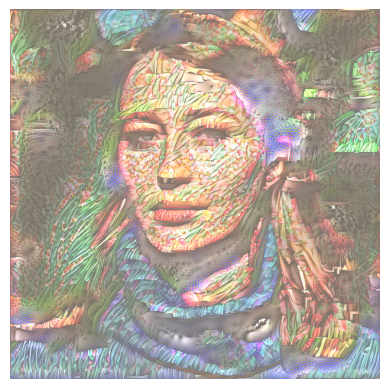

In [266]:
result = deprocess_image(generated_image.numpy())
plt.axis('off')
plt.imshow(result)